# About this tutorial
In this tutorial, we will focus on the pro-con and the narrative generation services. 

We will use a set of arguments collected from the crowd for the "That's debatable" show. The crowd was asked to contribute arguments for or against the topic **"It is time to redistribute the wealth"**.

We will start by running the pro-con service, in order to predict whether an argument is for or against the topic. Next, we  will see how we can improve the classification results. Finally, we will use these predictions in order to generate a narrative for the topic. 

# 1. Running pro-con service 

The pro-con service input is a list of dictionaries, each containing two keys: 'sentence' and 'topic', as follows - 

`arg_topic_dicts = [{'sentence': 'sentence_a', 'topic': 'topic_a'}, {'sentence': 'sentence_b', 'topic': 'topic_b'}]`

We will begin by collecting the data for these dictionaries, as well as the ground truth labels.

In [1]:
import os
from debater_python_api.api.debater_api import DebaterApi
from debater_python_api.api.clients.narrative_generation_client import Polarity
import csv

arguments_file = 'wealth_test_set.csv'
topic = 'It is time to redistribute the wealth'

with open(arguments_file, encoding='utf8') as csv_file:
    reader = csv.DictReader(csv_file)
    examples = list(reader)
    arguments = [example['sentence'] for example in examples]
    labels = [example['label'] for example in examples]

Next, we will create the debater_api object:

In [2]:
api_key = os.environ['DEBATER_API_KEY']
debater_api = DebaterApi(api_key)

Now we are ready to run the pro con service. 

The service returns a list of floats in the range [-1, 1], where each float is the prediction (score) for the corresponding sentence and topic. The sign of the score indicates if the service predicts that the argument supports the motion (positive score), or contests the topic (negative score). The absolute value of the score indicates the confidence of the prediction. Lower absolute value indicates low confidence, while high absolute value indicates high confidence.

Documentation for the pro-con service can be found here: https://early-access-program.debater.res.ibm.com/#pro_con


## Your turn!

Please write a code for the following:

1. Create a pro_con_client by calling the method `get_pro_con_client()` in the `debater_api` object.
2. Create a list in the format required for this client, using `topic` and `arguments` variables previously defined.
3. Run the pro-con client on this list, while storing the result in `pro_con_scores`.

In [3]:
pro_con_client = debater_api.get_pro_con_client()
sentence_topic_dicts = [{'sentence': argument, 'topic': topic} for argument in arguments]
pro_con_scores = pro_con_client.run(sentence_topic_dicts)

ProConClient:  99%|█████████▊| 500/507 [00:01<00:00, 313.44it/s]

# 2. Using pro con results
Now, we can use the service results and measure their accuracy. We will compare the service prediction to the labels created by human annotators. The label field contains three possible values: '1' for supporting arguments, '-1' for contesting arguments, and '0' for neutral or mixed arguments.

We will measure how many arguments were classified as supporting arguments, and what is the amount of arguments that were labeled as supporting arguments from this set, and print the accuracy of the prediction. 

We will repeat these steps for the contesting arguments as well. 

In [4]:
argument_score_label_list = list(zip(arguments, pro_con_scores, labels))

predicted_pro = [triple for triple in argument_score_label_list if triple[1] > 0]
predicted_pro_labeled_pro = [triple for triple in predicted_pro if triple[2] == '1']
print('predicted pro accuracy {}'.format(len(predicted_pro_labeled_pro) / len(predicted_pro)))

predicted_con = [triple for triple in argument_score_label_list if triple[1] < 0]
predicted_con_labeled_con = [triple for triple in predicted_con if triple[2] == '-1']
print('predicted con accuracy {}'.format(len(predicted_con_labeled_con) / len(predicted_con)))


predicted pro accuracy 0.6908517350157729
predicted con accuracy 0.7263157894736842


# 3. Looking into polarity errors:
We saw that the accuracy of our classifier is about 70%. This is very nice result, but let's look at the arguments that we missed and try to understand if we can improve the results.

In [5]:
def sign(x):
    if x > 0:
        return '1'
    return '-1'


arguments_with_wrong_polarity = [triple for triple in argument_score_label_list if sign(triple[1]) != triple[2]]
print('Arguments with wrong polarity:')
for triple in arguments_with_wrong_polarity[:10]:
    print('score: {}, label: {}, argument: {}'.format(triple[1], triple[2], triple[0]))

Arguments with wrong polarity:
score: 0.33737299777567387, label: 0, argument: The redistribution of income and the redistribution of wealth are, respectively, the transfer of income and wealth
score: -0.033621422946453094, label: 0, argument: access to economic-occupational opportunity structures would not be given by
factors particular to the youth group, but would be linked to factors affecting
the whole society regardless of the generational
score: -0.5180366635322571, label: 0, argument: It would not be so much like distributing wealth, it would be more at the same time changing and reconverting the tax system
score: 0.9841152523877099, label: -1, argument: Meritocracy is the only way to personal and business success, persevering thinking along with sacrificial actions should be rewarded.
score: 0.8739315569400787, label: -1, argument: If you work hard and succeed it is only right that you are able to keep your hard earned benefits
score: 0.8002817248925567, label: -1, argument: T

We can see that some arguments in the wrong polarity group are labeled as '0'. It means that the human annotators didn't think that these arguments have a clear stance. In addition, we can see that although there are few arguments with relatively high confidence (high absolute value) in this list, most of the arguments have a relatively low prediction confidence. 

A possible improvement will be to take into account not only the sign of the score but also its confidence. We can decide to classify either to pro or con classes if the prediction confidence is higher than some threshold and classify remaining arguments as undetermined or neutral.

How do we should choose such a threshold? Choosing a high threshold improves the precision of the classification, but reduces the coverage - it means that we will take into account only a limited portion of the arguments. 

# 4. Generating coverage-precision curve

In order to choose a threshold providing the optimal trade off between precision and coverage, we will print the coverage-precision curve for our pro-con results. For each given threshold, we can calculate the coresponding precision and coverage, and add the point (coverage, precision) to a graph on the coverage-precision plane. We will get a curve, parameterized by the threshold, which enables us to choose the correct threshold for our use case.  

ProConClient: 100%|██████████| 507/507 [00:04<00:00, 113.70it/s]


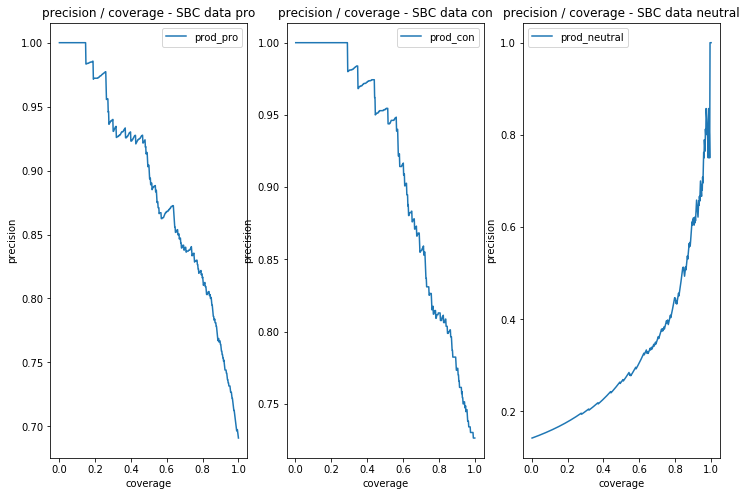

In [6]:
from wealth_util import calculate_statistics, plot_graph

pro_con_statistics = calculate_statistics('./wealth_test_set.csv', pro_con_scores)
plot_graph(examples_list=[pro_con_statistics], labels=['prod'])

We can see that for a 50% coverage, precision is about 93% for the pro arguments and almost 95% for the con arguments. For a coverage of 80%, precision will drop to about 82% in both for pro and con arguments.  

# 5. Fine-tuning the pro-con service
In order to improve the results, we can fine-tune the model we use on our data. The generic model which we used has been trained on 400,000 examples, collected from both newspapers and magazines dataset and from the crowd. The model is a transformer based model (https://en.wikipedia.org/wiki/Transformer_(machine_learning_model). It can be fine-tuned on a sample data from the desired domain in order to improve the service results. Experiments show that fine-tuning on even a relatively small sample from the desired domain can significantly improve results on said domain.

The debater early access program offers GPU based services for its services, but it is also possible to get a docker image of a given service and run it locally. Both CPU/GPU images can be provided.

Since the instances are shared between all of our users, we do not allow to train them. But as it is very simple to run our services locally, a user can get the image, fine-tune it quickly, and use it for inference.

In this tutorial we will show examples of running the pro-con service from a docker image on the virtual machine. Since the virtual machine doesn't have a GPU, we will use a CPU based image. It is important to mention that a GPU instance will run much faster than CPU instance (we use Nvidia K80 and run about 3000 example per minute, while running the same service on a mac with i9 core, 2.3GHz with 64 GB ram yields about 600 examples per minute).

In general, in order to fine-tune the pro-con service, we need a CSV file with three columns: motion (topic), sentence (argument), and label. Each line should be one example, with the topic and argument, and the correct label. The label enumeration should be '1' for pro arguments, '0' for con arguments, and '2' for neutral arguments. Note that these labels are different from the labels the service return at inference - a real number in the range [-1,1] where it signum represents it class (positive for pro arguments and negative for con arguments).

Sometimes even a few tens of examples can improve the basic model, and the more the merrier. A training parameter that can be configured is the number of training epochs. This parameter defines how many rounds we will apply to our training set. On the one hand training, many times will fit the model better to the data, but on the other hand, it can cause overfit, which means that it will match very well the training data set, in the cost of losing fit to the actual data. A simple rule of thumb is that we should try to increase the number of epochs when the training set is larger. 
At this tutorial, we use less than 500 examples, and therefore we will set the number of epochs to one. 

It is important not to train the model on the same arguments set that you use for evaluating the model since it  may overfit to the training set. It means that it might learn to perform very well on the test set while performing much worst on other data.  

In our tutorial, we will use a different set of arguments collected from the same event: [wealth_train_set.csv](./wealth_train_set.csv). 

## Your turn! Lets start to run a local pro-con service and recreate it.
1. Run local pro-con service:
- Open a new terminal tab (File -> New Tab).
- Run a docker command for runn the pro-con docker image and assign port 8000 to it:
`docker run -p 8000:8000  us.icr.io/ris2-debater/pro-con:4.4.b37`
- wait until this text appears: "run: server started"
2. Fine-tune it
- open the following url in chrome: http://localhost:8000/model.html
- under the title "Training data sets", click on "create" button.
- click on "choose file" button, and select wealth_train_set.csv.
- Give name to the new model near "Train new model" set "epochs" to 1, and click "start training".
- wait till the new model name will apear under "Available models". Choose the new model.  

Now you have a local service, fine tune with example from the same topic. 


# 6. Coverage-precision curve for the fine-tuned model.

In order to compare between the generic model and the fine-tuned model, you will generate again the precision coverage curve for the fine-tuned model, and then plot the two curves on the same graph. 

Start by setting the client host to http://localhost:8000 and then generate the pro-con scores the same way you did for the generic model. store the scores at the variable `ft_pro_con_scores`

In [7]:
pro_con_client.set_host('http://localhost:8000')
ft_pro_con_scores = pro_con_client.run(sentence_topic_dicts)

ProConClient:   0%|          | 0/507 [00:00<?, ?it/s]

Now we can calculate the statistics for the fine-tuned model, and pot the old and new statistics at the same graph.

ProConClient: 100%|██████████| 507/507 [00:02<00:00, 172.06it/s]


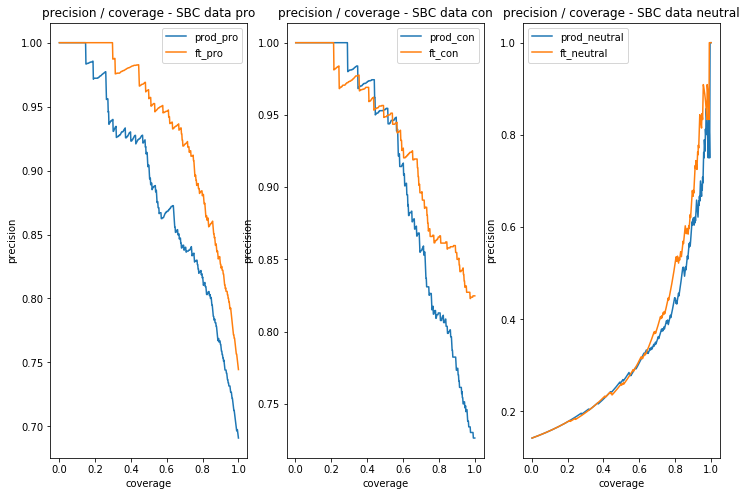

In [8]:
ft_pro_con_statistics = calculate_statistics('./wealth_test_set.csv', ft_pro_con_scores)
plot_graph(examples_list=[pro_con_statistics, ft_pro_con_statistics], labels=['prod', 'ft'])

We can see that the fine-tuning improved significantly our pro precision, and it also improved the con predictions for most of the coverages. We can see that for the con side, for coverage = 0.8, we get a precision of about 0.93.

# 7. Generating a narrative using the fine-tuned model 

Now, we ready to use the model predictions we have, with the value we choose, for creating a narrative. We will use the narrative generation client and create the speech.

In [18]:
dominant_concept = 'Redistribution of income and wealth'

customizations = \
    [
        {
            "title": "Number of paragraphs",
            "description": "Set an upper bound on number of paragraphs (each yielding a theme)",
            "type": "numParagraphsToSelect",
            "items":
                [
                    {
                        "key": "max_num_of_paragraphs",
                        "description": "recommended values: from 4 to 8",
                        "value": 3,
                        "itemType": "single_integer"
                    }
                ]
        },
        {
            "title": "Speech length in minutes",
            "description": "Set an upper bound on number of minutes the speech should last.",
            "type": "speechLengthInMinutes",
            "items":
                [
                    {
                        "key": "max_length_in_minutes",
                        "description": "A float number expressed as decimal with up to two digits to the right of the decimal point. Recommended values: from 2.0 to 4.0",
                        "value": 3,
                        "itemType": "single_float",
                    }
                ]
        },
        {
            "title": "System Polarity Threshold",
            "description": "Sets the threshold for filtering of arguments by their polarity score. Can specify absolute value, and / or fraction of the top scoring arguments. When both thresholds are specified, both are employed.",
            "type": "systemPolarityThreshold",
            "items":
                [
                    {
                        "key": "system_polarity_absolute_threshold",
                        "description": "Threshold, in the range [0,1]. Arguments whose procon score falls below that threshold will be filtered out.",
                        "value": 0.0,
                        "itemType": "single_float",
                    },
                    {
                        "key": "system_polarity_percentage_threshold",
                        "description": "Threshold, in the range [0,1]. Arguments whose rank, in the arguments sorted by their procon score, is not among the top threshold of the list, will be filtered out.",
                        "value": 0.8,
                        "itemType": "single_float",
                    }

                ]
        }
    ]


speech = debater_api.get_narrative_generation_client().run(topic=topic,
                                                           dc=dominant_concept,
                                                           sentences=arguments,
                                                           pro_con_scores=pro_con_scores,
                                                           polarity=Polarity.CON,
                                                           customizations=customizations)

print('\n\n' + str(speech))

09/05/2021 10:03:26, SpeechResultResponse=6097893db1f0d509663aaa3d, motionGenerationid=0, status=RUNNING, started to wait at 09/05/2021 10:03:25


Hello everybody. The crowd posted 507 arguments, opposing the claim that It is time to redistribute the wealth. Here is a summary. 

The crowd raised three issues. The first will demonstrate how a wealth transfer unduly punish the economic elite. Then, the topics of diligence and poverty will be elaborated on. 

Regarding economy.  Government control over monopolies and large companies that generate enormous financial capital would violate the free market, which could seriously affect the global economy.   The redistribution of wealth would lead to excessive state intervention that could seriously damage the world economic system.   Redistributing wealth is not a solution, wealth should be focused on generating opportunities equally, where meritocracy is not eliminated, since this would be the social and economic destruction of a country.   